## KQ3: Pritts Meta-analysis Update

In key question 3, we address the risk of sarcoma dissemination following morcellation of fibroids. We identified a recently published analysis conducted by Elizabeth Pritts and her colleagues (2015) to estimate the  prevalence of occult leiomyosarcoma at time of treatment for presumed benign tumors (fibroids).  We updated their search and used similar eligibility criteria to identify papers published since 2014. We extracted from these papers the number of women who were treated for uterine fibroids and the cases of leiomyosarcoma subsequently identified.  We have combined these data with the data from the 134 publications that Pritts et al included in their analysis for a total of LMS rates from 148 sources.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
import pdb
sns.set()

In [2]:
kq3_data = pd.read_excel('data/UF CER KQ3 Data for Analysis.xlsx', sheetname='5.UFKQ3Data', 
                         na_values=['NR', 'NA'],
                        index_col=0)[['Author', 'Year', 'Design', 'Procedure', 'Indication',
                                     'Age, Mean', 'Age, SD', 'Age, Median', 'Age, Min', 'Age, Max', 'Age, Other',
                                     'LMS','Population','Tumors','InPritts']].dropna(thresh=7)
kq3_data.head()

,Author,Year,Design,Procedure,Indication,"Age, Mean","Age, SD","Age, Median","Age, Min","Age, Max","Age, Other",LMS,Population,Tumors,InPritts
Line,,,,,,,,,,,,,,,
1,"Adelusola KA, Ogunniyi SO",2001,Retrospective,NE,NE,NaN,NaN,NaN,19,89,NaN,0,177,0,1
2,"Ahmed AA, Stachurski J, Abdel Aziz E et al",2002,Prospective,NE,NE,NaN,NaN,NaN,29,65,NaN,0,10,0,1
3,"Angle HS, Cohen SM, Hidlebaugh D",1995,Retrospective,NE,NE,41.0,NaN,NaN,24,81,NaN,0,41,0,1
4,"Banaczek Z, Sikora K, Lewandowska-Andruszuk I",2004,Retrospective,NE,NE,44.5,NaN,NaN,29,73,NaN,0,309,0,1
5,"Barbieri R, Dilena M, Chumas J, Rein MS, Fried...",1993,RCT,NE,NE,33.7,NaN,NaN,NaN,NaN,36.3,0,20,0,1


Breakdown on studies by design.

In [3]:
kq3_data.Design.value_counts()

Retrospective       83
Prospective         38
RCT                 26
Pop based cohort     1
Name: Design, dtype: int64

Following [Pritts et al. (2015)](http://www.ncbi.nlm.nih.gov/pubmed/26283890), I fit a binomial random effects model, such that event probabilities on the logit scale are normally distributed with mean $\mu$ and standard deviation $\sigma$. This distribution describes how the probabilities vary across studies, with the degree of variation described by $\sigma$.

$$\theta_i \sim N(\mu, \sigma^2)$$

the expected value for study $i$ is then inverse-logit transformed, and used as the event probability $\pi_i$ in a binomial model describing the number of observed tumors $t$:

$$\log\left[\frac{\pi_i}{1-\pi_i}\right] = \theta_i$$

$$t_i \sim \text{Bin}(n_i, \pi_i)$$

In [4]:
import theano.tensor as tt

model_data = kq3_data

k = model_data.shape[0]
tumors = model_data.Tumors.values.astype(int)
n = model_data.Population.values.astype(int)

def invlogit(x):
    return tt.exp(x) / (1 + tt.exp(x))

with pm.Model() as pritts_update:
    
    μ = pm.Normal('μ', 0, sd=100, testval=-3)
    σ = pm.Uniform('σ', 0, 1000, testval=10)
    θ = pm.Normal('θ', μ, sd=σ, shape=k)
    π = pm.Deterministic('π', invlogit(θ))
    
    p_update = pm.Deterministic('p_update', invlogit(μ))
    
    obs = pm.Binomial('obs', n=n, p=π, observed=tumors)

Applied interval-transform to σ and added transformed σ_interval to model.


In [14]:
with pritts_update:
    step = pm.NUTS()
    trace = pm.sample(2000, step=step, njobs=2)

 [-----------------100%-----------------] 2000 of 2000 complete in 273.4 sec

The following plots are the distribution of samples from the posterior distributions for the expected (population) probability of tumor (`p_update`), the inverse-logit expected probability ($\mu$) and the standard deviation of the probabilities on the inverse-logit scale ($\sigma$).

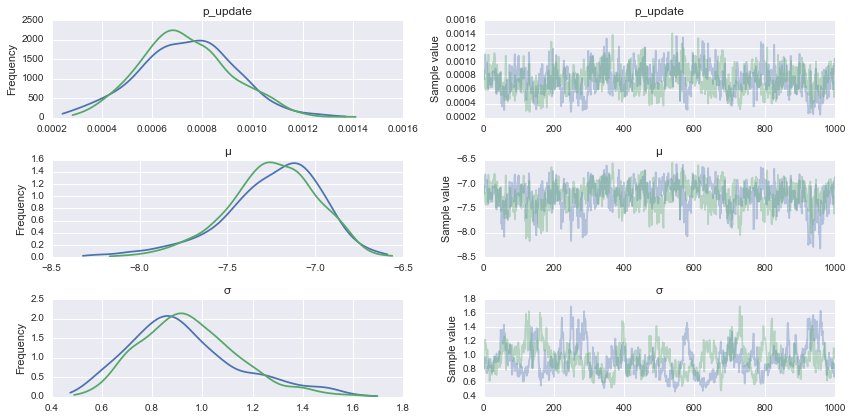

In [15]:
pm.traceplot(trace[1000:], varnames=['p_update', 'μ', 'σ']);

Summary statistics from each of the above parameters.

In [16]:
pm.summary(trace[1000:], varnames=['p_update', 'μ', 'σ'], roundto=4)


p_update:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.0007           0.0002           0.0000           [0.0004, 0.0011]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.0004         0.0006         0.0007         0.0009         0.0011


μ:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -7.2464          0.2723           0.0173           [-7.8293, -6.7733]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -7.8740        -7.4045        -7.2208        -7.0593        -6.8012


σ:

  Mean             SD               MC Error         95% HPD interval
  ---------------------

/Users/fonnescj/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


By comparison, estimates from Pritts' supplement:

![pritts estimates](http://fonnesbeck-dropshare.s3.amazonaws.com/Screen-Shot-2016-03-28-23-41-27.png)

Below is a forest plot of the posterior distribution of probabilities for each study.

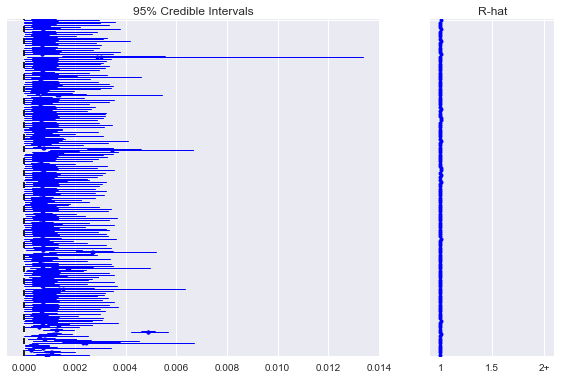

In [17]:
pm.forestplot(trace[1000:], varnames=['π'], ylabels=[''])

### Goodness of fit

To check how well the model fits the data, I conducted posteior predictive checks. This simulates data from the model for each data point (*i.e.* study) in the meta-analysis, and compares the distribution of these simulated values (here, 500 replicates) with the value of the data itself. If the percentile of the datum is very extreme (either large or small), then it is evidence that the model does not adequately fit the data. The distribution of percentiles in the bottom histogram shows that there is no evidence of lack of fit.

In [21]:
ppc = pm.sample_ppc(trace, model=pritts_update, samples=500)

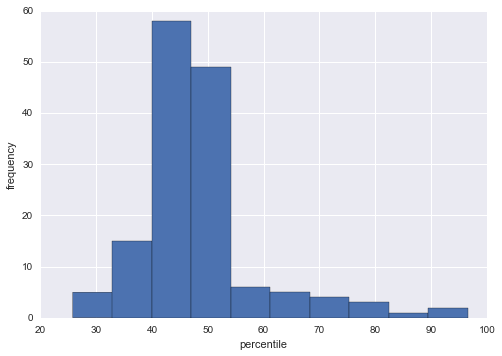

In [25]:
from scipy.stats import percentileofscore
        
p = [percentileofscore(s, o).round(2) for s,o in zip(ppc['obs'].T, tumors)]
        
plt.hist(p)
plt.xlabel('percentile')
plt.ylabel('frequency');